In [1]:
from web3 import Web3
import numpy as np
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import torch
import pandas as pd
#!pip install python-dotenv
import dotenv
import os

In [2]:
%load_ext dotenv
%dotenv

In [3]:
node_url=os.getenv("NODE_URL")
web3 = Web3(Web3.HTTPProvider(node_url))
print(web3.is_connected())

True


In [13]:
df_insertion = pd.read_csv ('../data/insertion_attacks.csv', delimiter=',')
print('# of insertion: ', len(df_insertion))

# of insertion:  196691


In [14]:
def get_max_block_number() -> int:
    return int(df_insertion["Block Number"].max())

In [15]:
df_insertion[df_insertion["Block Number"] >= get_max_block_number()]

,Block Number,First Attacker,Whale,Second Attacker,First-Whale Gas Price Delta,Whale-Second Gas Price Delta,Profit,Cost,Interface,Exchange,Token,Bot,Bot Cluster ID
195114,11299998,0xeD1cAa76a8cb7E671654A6c816a753acE6217BAE,0xf384aa91c1709Ec28b7422A2897E74f2d61036Cd,0xeD1cAa76a8cb7E671654A6c816a753acE6217BAE,10.09376,0.0,5.022881,4.400952,bot,Uniswap V2,yfi.group,0xEB46faa47A6A52519839A2e52c7b28a2Db17651e,37.0


In [16]:
def convert_from_wei_to_gwei(gas_price_in_wei):
    gas_price_in_gwei = float(web3.from_wei(gas_price_in_wei, "gwei"))
    return gas_price_in_gwei

In [17]:
def get_gas_prices_from_last_100_blocks(web3: Web3) -> list[int]:
    
    highest_block = get_max_block_number()    
    
    gas_prices = []
    for i in range(100):
        block = web3.eth.get_block(highest_block - i, full_transactions=True)
        
        for transaction in block.transactions:
            gas_prices.append(convert_from_wei_to_gwei(transaction["gasPrice"]))
        
    return gas_prices

In [18]:
gas_prices_last_100_blocks = get_gas_prices_from_last_100_blocks(web3)

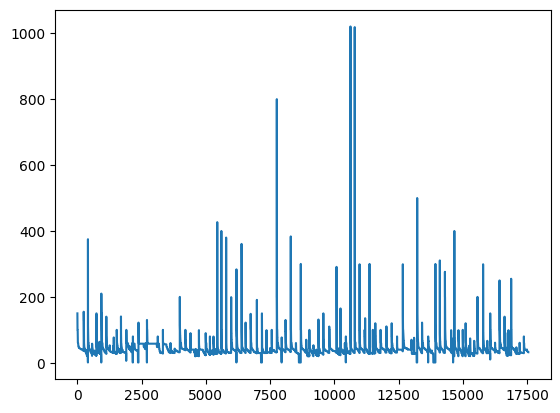

In [19]:
plt.plot(gas_prices_last_100_blocks)
plt.show()

In [20]:
train_size = int(len(gas_prices_last_100_blocks) * 0.8)

train = gas_prices_last_100_blocks[:train_size]
test = gas_prices_last_100_blocks[train_size:]

mean_train = np.mean(train, axis=0)
std_train = np.std(train, axis=0)

def standardize(X, mean, std):
    return (X - mean) / std

def inverse_standardize(X, mean, std):
    return X * std + mean

# standardize both X_train and X_val
train = standardize(train, mean_train, std_train)
test = standardize(test, mean_train, std_train)

In [21]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookback]
        X.append(feature)
        y.append(target)
    return torch.tensor(X).view(len(X), lookback, 1).type(torch.float32), torch.tensor(y).view(len(y)).type(torch.float32)

lookback = 15
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([14024, 15, 1]) torch.Size([14024])
torch.Size([3495, 15, 1]) torch.Size([3495])


C:\Users\larsh\AppData\Local\Temp\ipykernel_20652\1074192916.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(X).view(len(X), lookback, 1).type(torch.float32), torch.tensor(y).view(len(y)).type(torch.float32)


In [22]:
# source https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fully_connected = torch.nn.Linear(hidden_size, output_size)
        self.dropout = torch.nn.Dropout(0.2)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        dropout = self.dropout(out)
        return  self.fully_connected(dropout[:, -1, :])

In [23]:
# define parameters
epochs = 100
nr_input_features = 1
hidden_neurons = 32
hidden_layer = 1
output = 1
learning_rate = 0.001
momentum = 0.9
batch_size = 128

model = LSTM(nr_input_features, hidden_neurons, hidden_layer, output)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
loss_fn = torch.nn.MSELoss()

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)

train_mse_loss = []

for epoch in range(epochs):
    train_loss = 0.0
    total_sample = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze(dim=-1)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
        total_sample += X_batch.size(0)
    train_mse_loss.append(train_loss / total_sample)
    print("Epoch %d: train MSE %.4f" % (epoch, train_loss / total_sample))

Epoch 0: train MSE 0.9407
Epoch 1: train MSE 0.8421
Epoch 2: train MSE 0.7700
Epoch 3: train MSE 0.7070
Epoch 4: train MSE 0.6772
Epoch 5: train MSE 0.6589
Epoch 6: train MSE 0.6465
Epoch 7: train MSE 0.6333
Epoch 8: train MSE 0.6288
Epoch 9: train MSE 0.6243
Epoch 10: train MSE 0.6154
Epoch 11: train MSE 0.6127
Epoch 12: train MSE 0.6051
Epoch 13: train MSE 0.6048
Epoch 14: train MSE 0.5981
Epoch 15: train MSE 0.5970
Epoch 16: train MSE 0.5948
Epoch 17: train MSE 0.5865
Epoch 18: train MSE 0.5857
Epoch 19: train MSE 0.5943
Epoch 20: train MSE 0.5883
Epoch 21: train MSE 0.5886
Epoch 22: train MSE 0.5798
Epoch 23: train MSE 0.5742
Epoch 24: train MSE 0.5808
Epoch 25: train MSE 0.5875
Epoch 26: train MSE 0.5791
Epoch 27: train MSE 0.5738
Epoch 28: train MSE 0.5767
Epoch 29: train MSE 0.5709
Epoch 30: train MSE 0.5723
Epoch 31: train MSE 0.5791
Epoch 32: train MSE 0.5752
Epoch 33: train MSE 0.5675
Epoch 34: train MSE 0.5656
Epoch 35: train MSE 0.5590
Epoch 36: train MSE 0.5617
Epoch 37: t

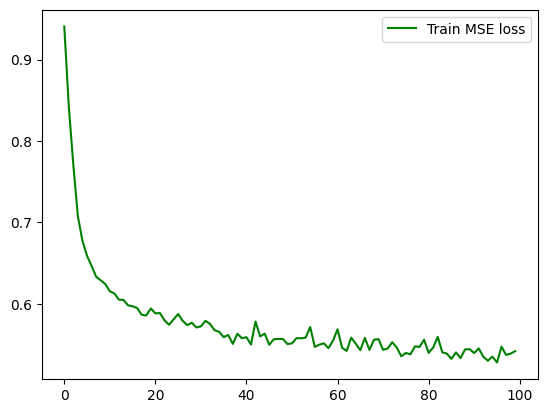

In [24]:
plt.plot(train_mse_loss, "g-", label="Train MSE loss")
plt.legend()
plt.show()

In [25]:
model.eval()
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(gas_prices_last_100_blocks) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1]
    train_plot[lookback:train_size] = model(X_train)[:, -1]
    test_plot = np.ones_like(gas_prices_last_100_blocks) * np.nan
    test_plot[train_size+lookback:len(gas_prices_last_100_blocks)] = model(X_test)[:, -1]

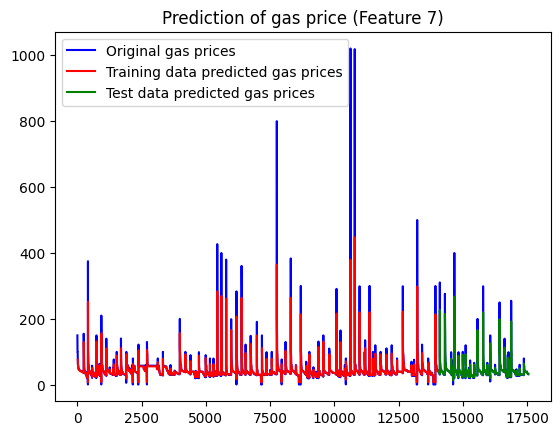

In [26]:
train_plot = inverse_standardize(train_plot, mean_train, std_train)
test_plot = inverse_standardize(test_plot, mean_train, std_train)

plt.plot(gas_prices_last_100_blocks, c='b', label="Original gas prices")
plt.plot(train_plot, c='r', label="Training data predicted gas prices")
plt.plot(test_plot, c='g', label="Test data predicted gas prices")
plt.title('Prediction of gas price (Feature 7)')
plt.legend()
plt.show()

In [27]:
# save model
torch.save(model.state_dict(), './lstm-feature-7-weights.pth')

# save mean and std
torch.save(mean_train, 'mean_train.pt')
torch.save(std_train, 'std_train.pt')